**Approximate Approach for Training Unconstrained Gaussian Radial Basis Function (RBF) Networks with Probabilistic Center Distribution**

This code demonstrates the *Approximate* training algorithm developed for standalone unconstrained RBF network models for nonlinear transient chemical process systems. The structure of the RBF model is optimized by varying the number of nodes / neurons / centers in hidden layer based on a recursive approach for minimizing the corrected Akaike Information Criteria (AICc). 

Two different types of center distributions are chosen for Gaussian RBF networks, i.e., deterministic (fixed) and **probabilistic (stochastic)**. While the deterministic distribution refers to assigning constant values to the centers / widths of the RBFs, the stochastic distribution considers sampling the centers from Gaussian distributions having the same mean and variances as the model inputs. The solution space is parameterized by representing the RBF centers / widths and the means / variances of the center distributions as additional model parameters to be estimated during training of the optimal RBF network models with deterministic and stochastic centers, respectively, in addition to the connection weights in the output layer of the network models. 

In the *Approximate* approach, the RBF centers / widths are either assigned some fixed deterministic / probabilistic values (without optimization), followed by only estimating the connection weights in the output layer of the network model while increasing the number of centers sequentially to obtain the specific model architecture corresponding to the minimum value of AICc.

*Load the training and validation datasets and specify the input and output variables for the RBF models. Note that the user can consider any dynamic dataset for training and validation. The rows signify the time steps for transient data and the columns signify the input and output variables.*

*The nonlinear dynamic continuous stirred tank reactor (CSTR) system is chosen for demonstration of the proposed approach.*

In [1]:
import numpy as np
import scipy as sp
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from idaes.core.solvers import get_solver
get_solver()
import matplotlib.pyplot as plt
import pandas as pd
from pyDOE import *
import math as mt
import time
import json
import pickle

In [2]:
# Loading the data for model development

data = pd.read_excel("Dynamic CSTR Data.xlsx","Data", header=None).values
data = data[2:1202, 1:]

# For this specific system, the first five columns are the model inputs and the following four columns are the model outputs

input_data = data[:,0:5]
output_data = data[:,5:]

**Defining Function for Recursive Selection of Number of Centers and Estimation of Connection Weights for the Unconstrained RBF Model**

In [3]:
def GRBF_prob_cen_AICc(input_data,output_data):
    data = np.concatenate((input_data, output_data), axis = 1)
    ni = input_data.shape[1]
    no = output_data.shape[1]
    nt = ni+no
    
    tt = data.shape[0]
    tn = int(np.floor(0.7*tt))
    
    # Normalizing the input and output variables

    norm_mat = np.zeros((tt,nt))
    delta = np.zeros((1,nt))
    for i in range(nt):
        delta[:,i] = max(data[:,i]) - min(data[:,i])
        norm_mat[:,i] = (data[:,i] - min(data[:,i]))/delta[0,i]

    Imat = norm_mat[:,0:ni]; Imat = Imat.transpose();
    dsr = norm_mat[:,ni:ni+no]; dsr = dsr.transpose();
    
    # TRAINING OF RBFNN

    tr_steps = np.random.choice(tt, tn, replace=False)
    tr_steps = np.sort(tr_steps) 
    
    dsr_t = np.zeros((no,tn))
    Imat_t = np.zeros((ni,tn))
    
    for i in range(tn):
        ts = tr_steps[i]
        dsr_t[:,i] = dsr[:,ts]
        Imat_t[:,i] = Imat[:,ts]


    # Training Input: Imat_t
    # Training Output: dsr_t

    check = np.inf

    n_tc = min([250, tn])
    sigma_arr = np.zeros((ni,1))
    
    for tc in range(n_tc):
        tc_steps = np.random.choice(tn, tc, replace=False)
        tc_steps = np.sort(tc_steps)
               
        # Definining widths for the neurons in hidden layer
        for k in range(ni):
            sigma_arr[k] = np.std(Imat_t[k])
            
        sigma = 5*np.mean(sigma_arr)
        
        # Definining centers for the neurons in hidden layer
        centermat = np.zeros((ni,tc))
        
        for j in range(ni):
            centermat[j,:] = np.random.normal(np.mean(Imat_t[j,:]),sigma_arr[j],tc)
        
        D = np.zeros((tc,tn))
        
        for i, c in enumerate(centermat.T):
            D[i,:] =  np.linalg.norm(Imat_t.T - c, 2, axis = 1)

        PhiofD = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(D*D)/(2*sigma**2))
        
        z = np.dot(np.linalg.pinv(PhiofD.T) , dsr_t.T);
        
        # Generating Training Outputs
        yRBF = np.dot(np.transpose(PhiofD),z)
        dsr_tt = np.transpose(dsr_t)
        
        eps = np.transpose(dsr_tt - yRBF)
        R = 0.1*np.eye(no)
        
        k = ni*tc + 1 + z.shape[0]*z.shape[1]
        
        n_AIC = tn; m_AIC = no;
        
        #llh = (-n_AIC*m_AIC/2)*np.log(2*np.pi) - 0.5*n_AIC*np.log(np.linalg.det(R)) - 0.5*(1/m_AIC)*(1/n_AIC)*np.dot(np.dot(np.sum(eps,\
        #           axis=1), np.linalg.inv(R)),  np.transpose(np.sum(eps, axis=1)))

        llh = (-n_AIC*m_AIC/2)*np.log(2*np.pi) - 0.5*n_AIC*np.log(np.linalg.det(R)) - 0.5*np.dot(np.dot(np.sum(eps, axis=1), \
                    np.linalg.inv(R)),  np.transpose(np.sum(eps, axis=1)))
        
        AICc = -2*llh + 2*k + 2*k*(k+1)/(n_AIC - k - 1)
              
        if (AICc < check):
            check = AICc
            z_f = z
            centermat_f = centermat
            sigma_f = sigma
            num_of_centers = tc

    z = z_f; centermat = centermat_f; sigma = sigma_f;
    
    return [z,centermat,sigma,num_of_centers]

In [4]:
# Generate the results for entire data

[z,centermat,sigma,num_of_centers] = GRBF_prob_cen_AICc(input_data,output_data)

data = np.concatenate((input_data, output_data), axis = 1)
ni = input_data.shape[1]
no = output_data.shape[1]
nt = ni+no
    
tt = data.shape[0]
    
# Normalizing the input and output variables

norm_mat = np.zeros((tt,nt))
delta = np.zeros((1,nt))
for i in range(nt):
    delta[:,i] = max(data[:,i]) - min(data[:,i])
    norm_mat[:,i] = (data[:,i] - min(data[:,i]))/delta[0,i]

in_norm = norm_mat[:,0:ni]; in_norm = in_norm.transpose();
out_norm = norm_mat[:,ni:ni+no]; out_norm = out_norm.transpose();

dsr_v = out_norm; Imat_v = in_norm;

D = np.zeros((num_of_centers,tt))
        
for i in range(num_of_centers):
    for j in range(tt):
        D[i,j] = np.linalg.norm((centermat[:,i] - Imat_v[:,j]))

yHL = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(D*D)/(2*sigma**2))

yRBF = np.dot(np.transpose(yHL),z)

target_data = np.zeros((tt,no))
yRBF_unnorm = np.zeros((tt,no))

for i in range(no):
    target_data[:,i] = np.transpose(dsr_v[i])*delta[0,ni+i] + min(data[:,ni+i])
    yRBF_unnorm[:,i] = yRBF[:,i]*delta[0,ni+i] + min(data[:,ni+i])


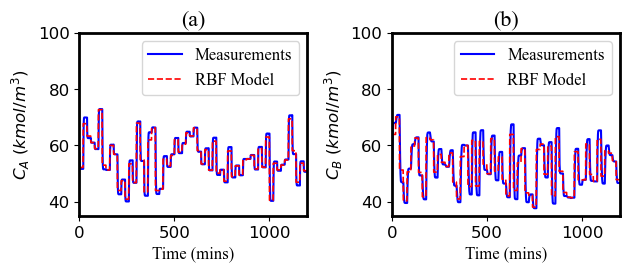

In [5]:
# Plotting Results

plt.rcParams.update(
    {
        "figure.max_open_warning": 0,
        "axes.titlesize": 16,
        "axes.labelsize": 12,
        "axes.linewidth": 2,
        "lines.linewidth": 3,
        "lines.markersize": 10,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "savefig.bbox": "tight",
        "legend.fontsize": "medium",
    }
)

plt.subplot(2,2,1)
plt.plot(target_data[:,0], color = 'blue', linewidth = 1.5, label = 'Measurements')
plt.plot(yRBF_unnorm[:,0], color = 'red', linewidth = 1.2, linestyle = '--', label = 'RBF Model')
plt.xlim(0, target_data.shape[0])
plt.xlabel('Time (mins)', fontname='Times New Roman')
plt.ylabel('$C_A$ ($kmol/m^3$)')
plt.ylim(35,100)
plt.title("(a)", fontname='Times New Roman')
plt.legend(loc='upper right',prop={'family': 'Times New Roman', 'size': 12})
plt.subplot(2,2,2)
plt.plot(target_data[:,1], color = 'blue', linewidth = 1.5, label = 'Measurements')
plt.plot(yRBF_unnorm[:,1], color = 'red', linewidth = 1.2, linestyle = '--', label = 'RBF Model')
plt.xlim(0, target_data.shape[0])
plt.xlabel('Time (mins)', fontname='Times New Roman')
plt.ylabel('$C_B$ ($kmol/m^3$)')
plt.ylim(35,100)
plt.title("(b)", fontname='Times New Roman')
plt.legend(loc='upper right',prop={'family': 'Times New Roman', 'size': 12})

plt.tight_layout()
plt.show()